# Сводные таблицы (Pivot Tables)

## Мотивирующие сводные таблицы

Для примеров в данной секции мы будем использовать набор данных о пассажирах на Титанике, доступный через библиотеку Seaborn.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Вручную созданные сводные таблицы

Мы начнём с группировки людей по полу и выживаемости. Очевидно, что можно использовать операцию `GroupBy` и получить что-то такое:

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


Но что если мы хотим получить данные о выживаемости по полу и классу каюты. С помощью `GroupBy` это могло бы выглядеть так:

In [8]:
titanic.groupby(['sex', 'class'], observed=False)['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Мы получили нужный результат, но код выглядит переусложненным. Для подобных, двумерных `GroupBy`, Pandas включает удобный метод `pivot_table`.

## Синтакс для сводных таблиц (pivot table)

Далее следует эквивалент выражения использованного ранее, но с помощью метода `pivot_table`:

In [10]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Такой код выглядит уже намного более читаемым.

### Многоуровневые сводные таблицы

Также как и с `GroupBy`, группировка в сводных таблицах может быть указана с помощью многих уровней и через целый набор опций. Например, мы можем быть заинтересованы в третьем измерении по возрасту. Для этого мы используем функцию `pd.cut`:

In [14]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', index=['sex', age], columns='class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

Мы можем применить аналогичную стратегию для добавления нового измерения, например по уплаченной сумме:

In [17]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', index=['sex', age], columns=[fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

### Дополнительные опции сводных таблиц

Полная сигнатура метода `pivot_table` выглядит [следующим](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html#pandas.pivot_table) образом:

```python
pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=_NoDefault.no_default, sort=True)
```

Мы уже поработали с первыми тремя аргументами, далее мы рассмотрим другие. Две опции `fill_value` и `dropna` достаточно понятные и рассматриваться не будут.

`aggfunc` - задаёт тип применяемого агрегирования, который по умолчанию вычисляет среднее. Как и в `GroupBy` в этом параметре может быть или строка, задающая функцию (`sum`, `mean`, `count`, `min`, `max`) или функция, которая реализует агрегацию (`np.sum()`, `min()`, `sum()`). Дополнительно этот параметр может содержать словарь, сопоставляющий колонку с одной из опций:

In [20]:
titanic.pivot_table(
    index='sex', columns='class',
    aggfunc={'survived':'sum', 'fare':'mean'}
)

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Иногда бывает необходимо подсчитать суммарные значения по группам. Для этого используется ключевое слово `margins`:

In [21]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


# Пример: данные о рождаемости


In [27]:
# shell command to download the data:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [24]:
births = pd.read_csv('notebooks/data/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


Давайте добавим данные о декадах и посмотрим на рождаемость по полу и декаде:

In [26]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Мы видим, что рождаемость мальчиков всегда выше рождаемости девочек. Давайте визуализируем эти данные:

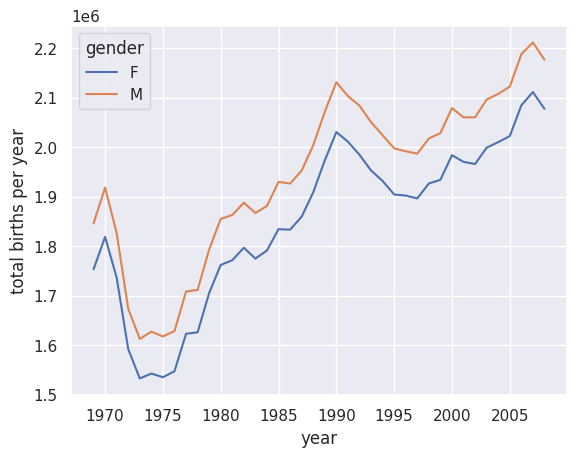

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

### Дальнейшие исследования данных

Одним из дальнейших направлений действий, может быть очистка данных от локальных выбросов, например неправильные даты (31 июня) или отсутствующие значения (99 июня). Одним из способов сразу убрать все выбросы, это воспользоваться операцией сигма-отсечения:

In [36]:
# чё за хрень тут происходит?
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

Мы можем использовать метод `query` для отфильтровывания дней рождения за пределами этих значений:

In [37]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Далее мы установим колонку `day` в целочисленные значения:

In [40]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

Наконец, мы можем скомбинировать день, месяц и год для создания индекса даты. Это позволит нам быстро вычислять день недели, соответствующий каждому ряду:

In [43]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(
    10000 * births.year +100 * births.month +births.day, format='%Y%m%d'
)

births['dayofweek'] = births.index.dayofweek

Теперь мы можем отрисовать график рождения по дня для нескольких декад:

/tmp/ipykernel_29633/698883515.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


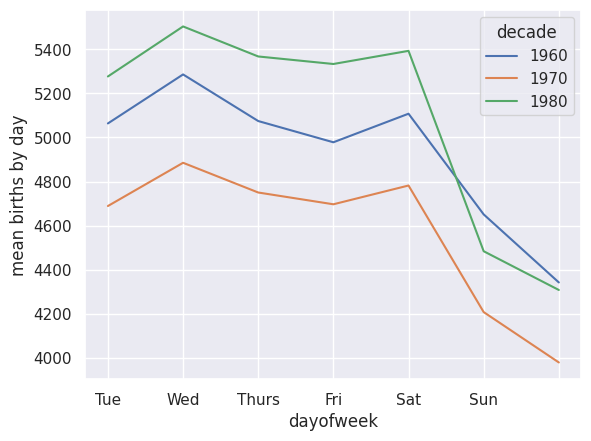

In [46]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Другой интересный разрез - это среднее количество рождений по дням в году. Давайте сгруппируем данные по месяцам и дня по отдельности:

In [48]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

Результат является многоиндексными данными. Для того, чтобы сделать их легко отображаемыми, давайте превратим эти месяца и дни в дату, путём ассоциации их с каким-либо любым годом, но важно, чтобы это был високосный год, чтобы не потерять данные за 29 февраля:

In [66]:
import datetime
datetime.datetime(2012, 1, 1)
births_by_date.index = [datetime.datetime(2012, ts.month, ts.day) for ts in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


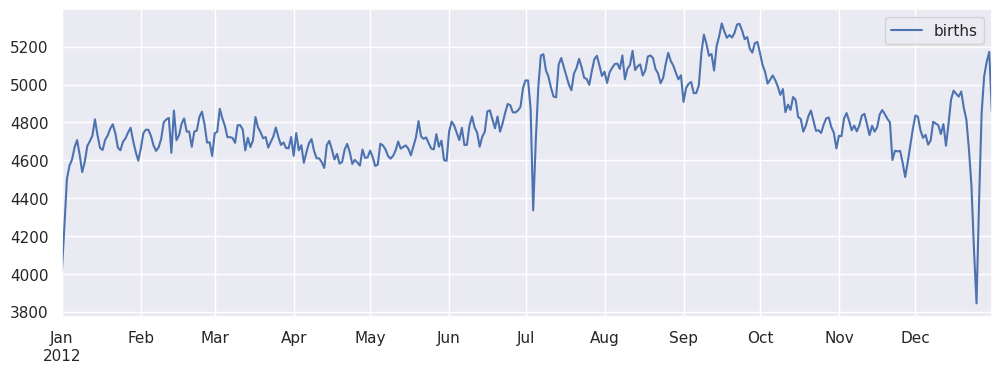

In [67]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);